# Instalação das dependências

Necessário instalar o tesseract na máquina. Como o Colab utiliza um computador com sistema operacional Linux, é preciso utilizar o comando `!sudo apt install tesseract-ocr`.

Informação disponível na [documentação do tesseract](https://tesseract-ocr.github.io/tessdoc/Installation.html)

Na mesma documentação é possível ver as linguagens disponíveis no [github](https://github.com/tesseract-ocr/tessdata). Para utilizar a língua portuguesa, precisamos usar o arquivo `por.tessdata`

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!pip install pytesseract

Podemos baixar diretamente o arquivo `por.tessdata` do [github](https://github.com/tesseract-ocr/tessdata) ou baixar diretamente para o Google Colab com o comando `wget`.

In [ ]:
!mkdir tessdata

mkdir: cannot create directory ‘tessdata’: File exists


In [24]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!git clone https://github.com/GabrielGabuu/Capturando_Placas


--2025-08-29 14:56:46--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/refs/heads/main/por.traineddata [following]
--2025-08-29 14:56:47--  https://github.com/tesseract-ocr/tessdata/raw/refs/heads/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/refs/heads/main/por.traineddata [following]
--2025-08-29 14:56:47--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/refs/heads/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

# Importação de bibliotecas

In [ ]:
import cv2
import pytesseract
import seaborn as sns
import numpy as np
import re
from google.colab.patches import cv2_imshow
from skimage.segmentation import clear_border

# Captura e tratamento de imagem

In [ ]:
foto_placa = cv2.imread('/content/placa_carro1.png')
foto_carro_lateral = cv2.imread('/content/placa_carro2.jpg')
foto_carro_centro = cv2.imread('/content/placa_carro3.jpg')

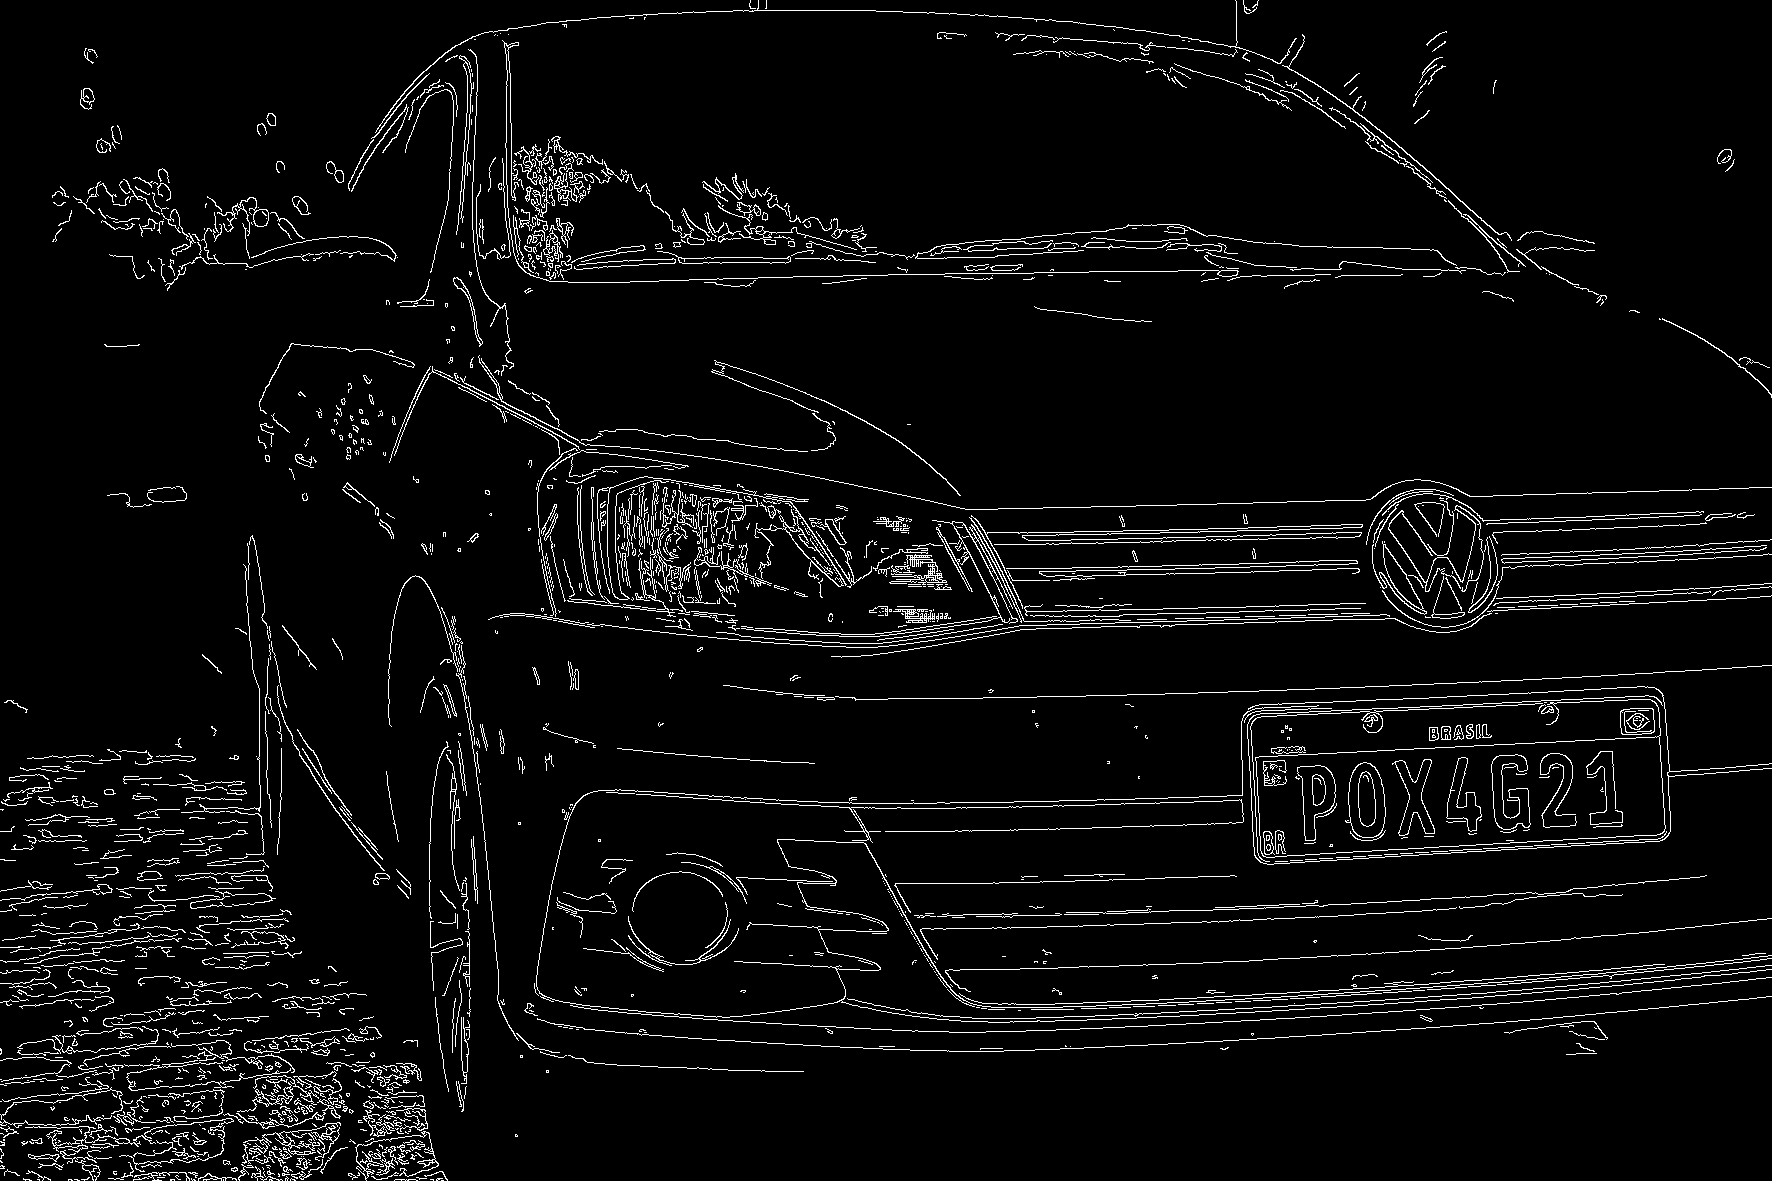

In [ ]:
def bgr_to_gray(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def image_to_text(image, lang, config):
  text = pytesseract.image_to_string(image, lang=lang, config=config)
  return text
def erosaoOtsu(image):
  valor, lim_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  erosao = cv2.erode(lim_otsu, cv2.getStructuringElement(cv2.MORPH_RECT, (4,4)))
  return erosao

gray = bgr_to_gray(foto_carro_lateral)
# gray = otsu(gray)
bordas = cv2.Canny(gray, 100, 200)
cv2_imshow(bordas)

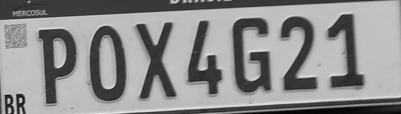

In [ ]:

def localizar_placa(imagem_gray, bordas):
    """
    Localiza uma placa em uma imagem, caso exista.

    Parâmetros:
        imagem_gray: imagem em escala de cinza.
        bordas: imagem binária das bordas (ex.: Canny).

    Retorna:
        placa (ROI da placa em escala de cinza) ou None se não encontrar.
    """
    contornos, hierarquia = cv2.findContours(bordas, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contornos = sorted(contornos, key=cv2.contourArea, reverse=True)[:10]

    for contorno in contornos:
        epsilon = 0.02 * cv2.arcLength(contorno, True)
        aproximacao = cv2.approxPolyDP(contorno, epsilon, True)

        if cv2.isContourConvex(aproximacao) and len(aproximacao) == 4:
            x, y, w, h = cv2.boundingRect(aproximacao)
            return imagem_gray[y:y + h, x:x + w]

    return None

placa = localizar_placa(gray, bordas)
cv2_imshow(placa)


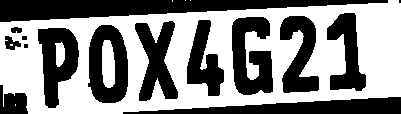

In [ ]:
erosao = erosaoOtsu(placa)
cv2_imshow(erosao)

In [ ]:
text = image_to_text(erosao, 'por', '--tessdata-dir tessdata --psm 6')
print(text)

“POX4E21



In [ ]:
texto_extraido = re.search(r'\w{3}\d{1}\w{1}\d{2}', text)
print(texto_extraido.group(0))

POX4E21


## Técnica Chapéu preto para tramento mais complexo

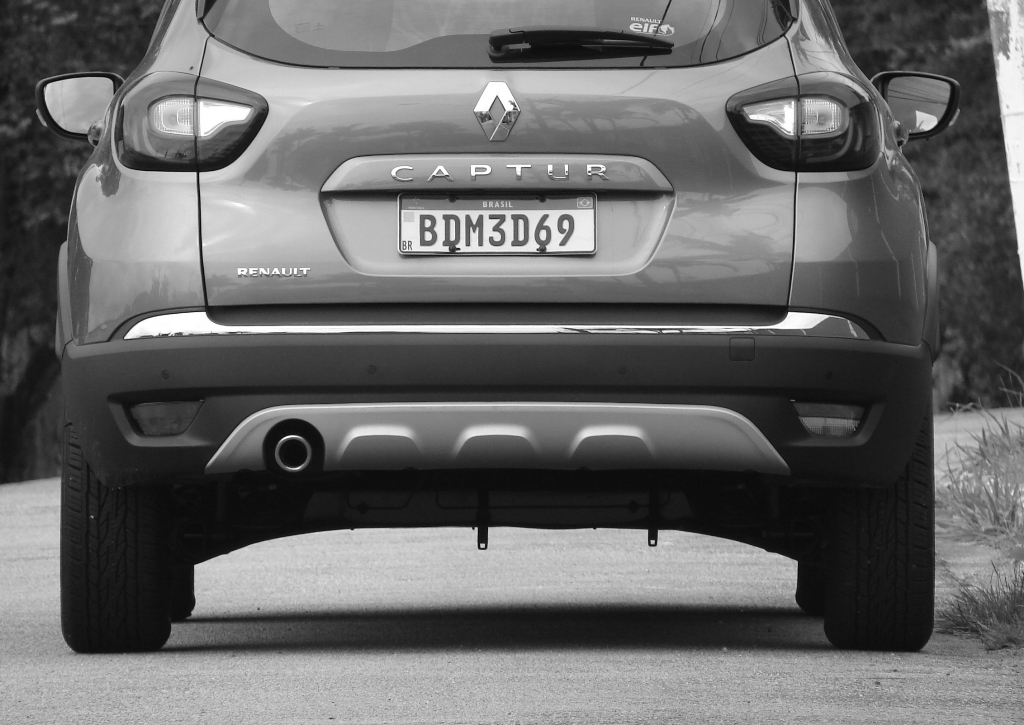

In [ ]:
carro = bgr_to_gray(foto_carro_centro)
cv2_imshow(carro)

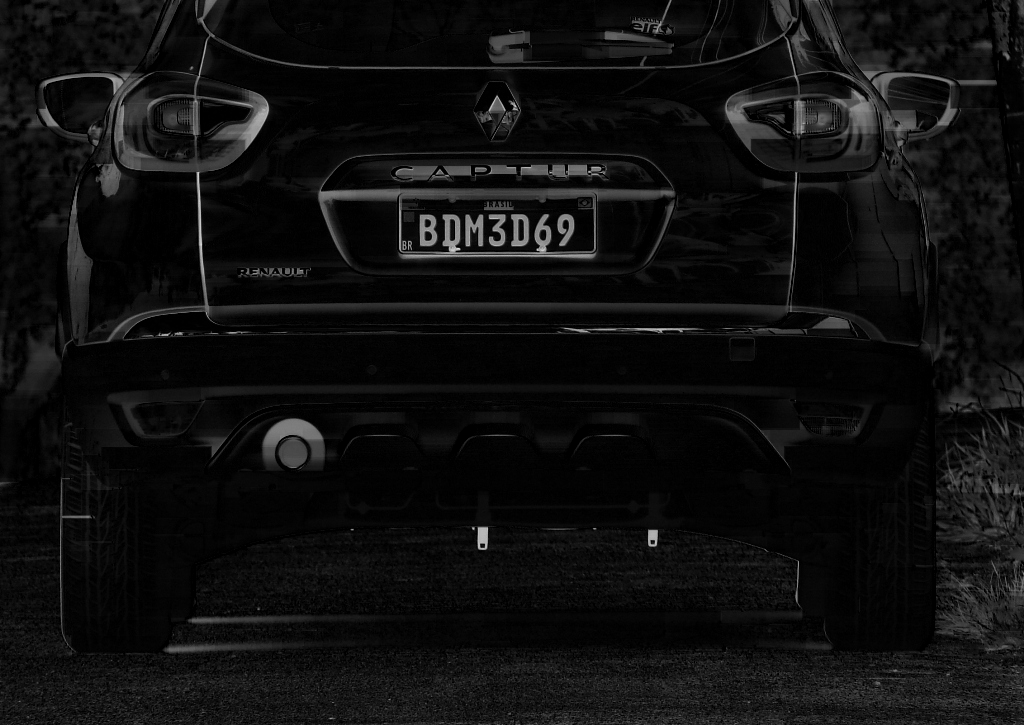

In [ ]:
kernel_retangular = cv2.getStructuringElement(cv2.MORPH_RECT, (40,13))
chapeu_preto = cv2.morphologyEx(carro, cv2.MORPH_BLACKHAT, kernel_retangular)
cv2_imshow(chapeu_preto)

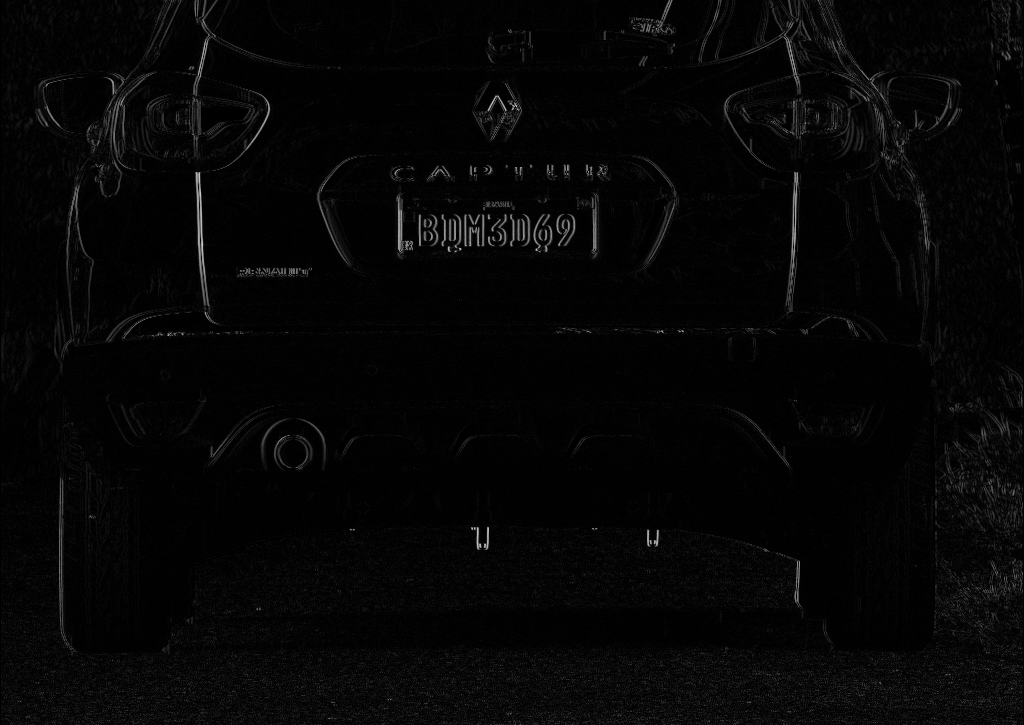

In [ ]:
sobel_x = cv2.Sobel(chapeu_preto, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = 1)
sobel_x = np.absolute(sobel_x)
sobel_x = sobel_x.astype('uint8')
cv2_imshow(sobel_x)

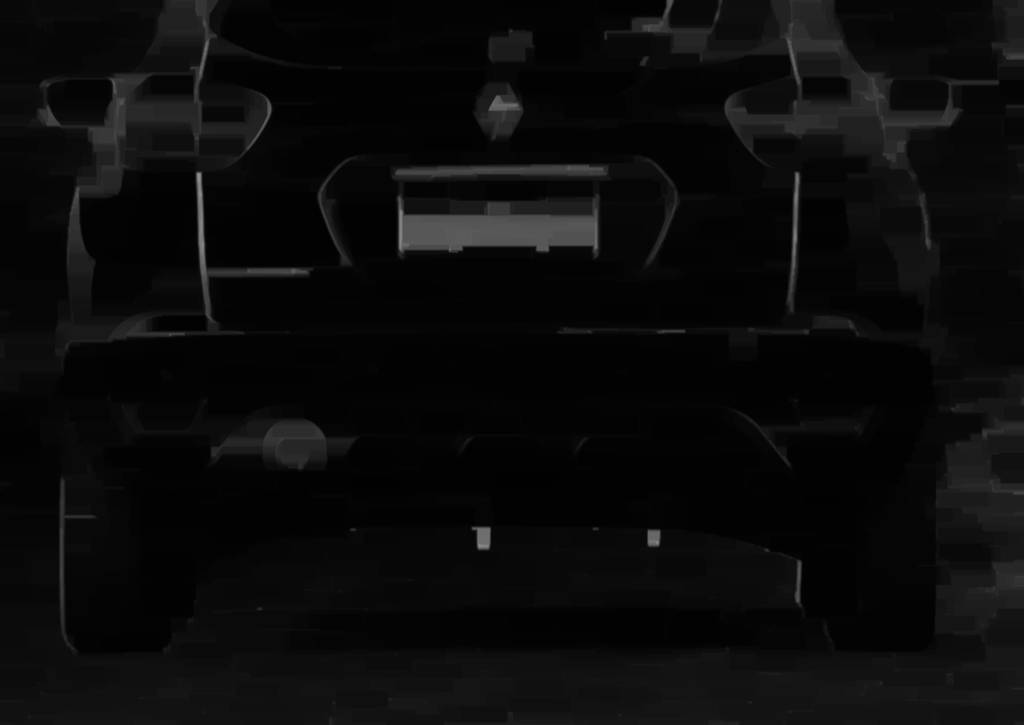

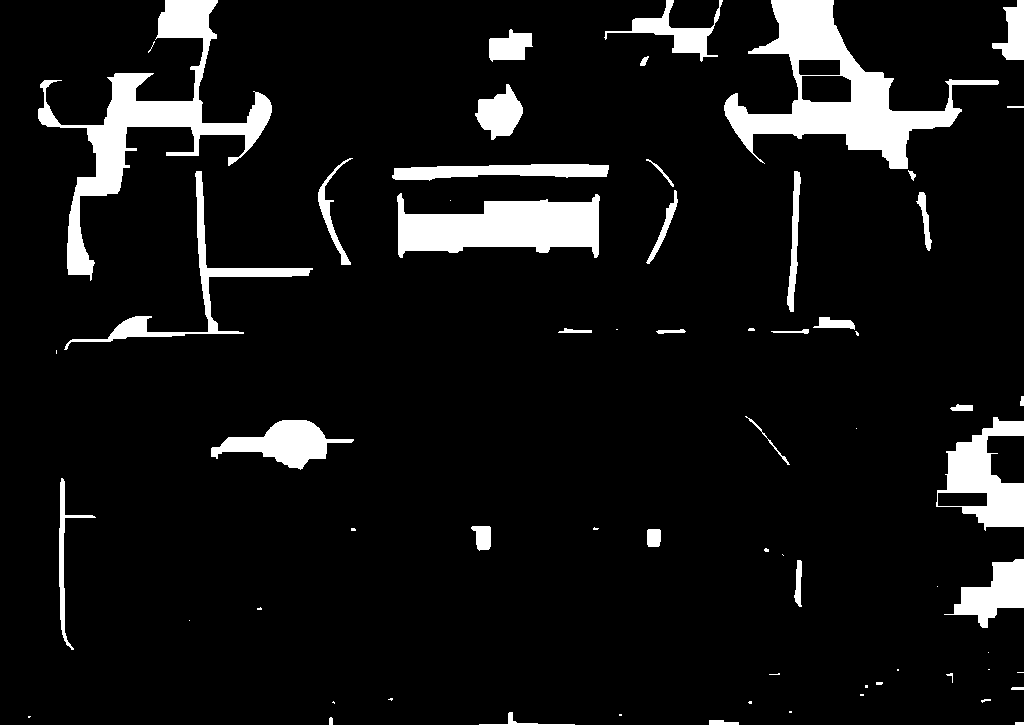

In [ ]:
sobel_x= cv2.GaussianBlur(sobel_x, (5,5), 0)
sobel_x = cv2.morphologyEx(sobel_x, cv2.MORPH_CLOSE, kernel_retangular)
cv2_imshow(sobel_x)
valor, limiarizacao = cv2.threshold(sobel_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(limiarizacao)

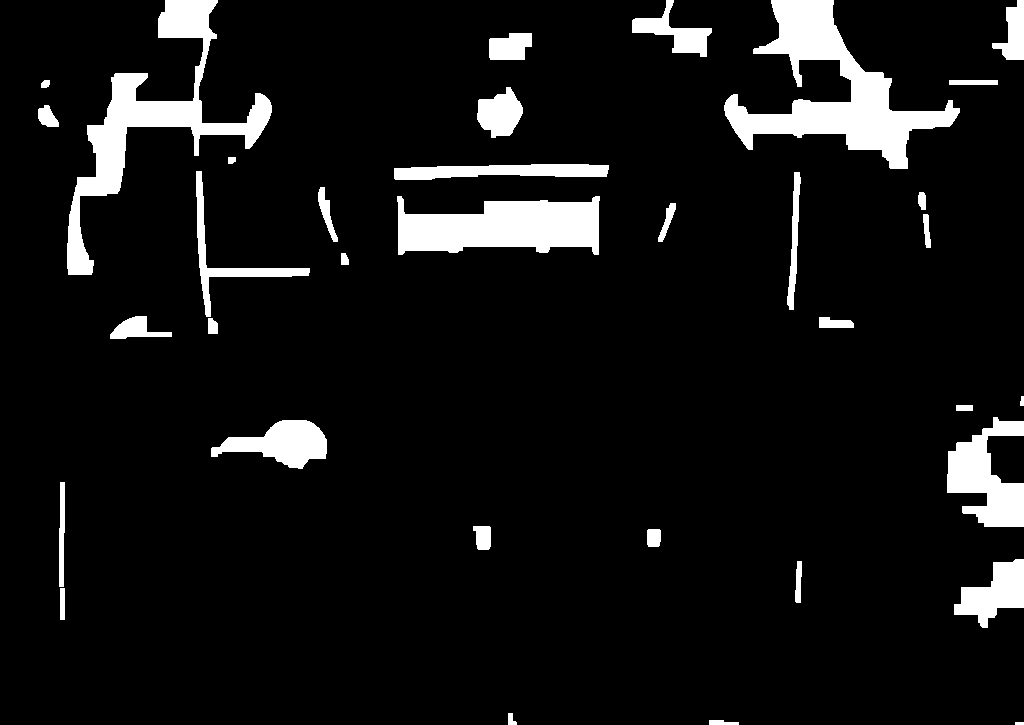

In [ ]:
kernel_quadrado = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
limiarizacao = cv2.erode(limiarizacao, kernel_quadrado, iterations = 2)
limiarizacao = cv2.dilate(limiarizacao, kernel_quadrado, iterations = 2)
cv2_imshow(limiarizacao)

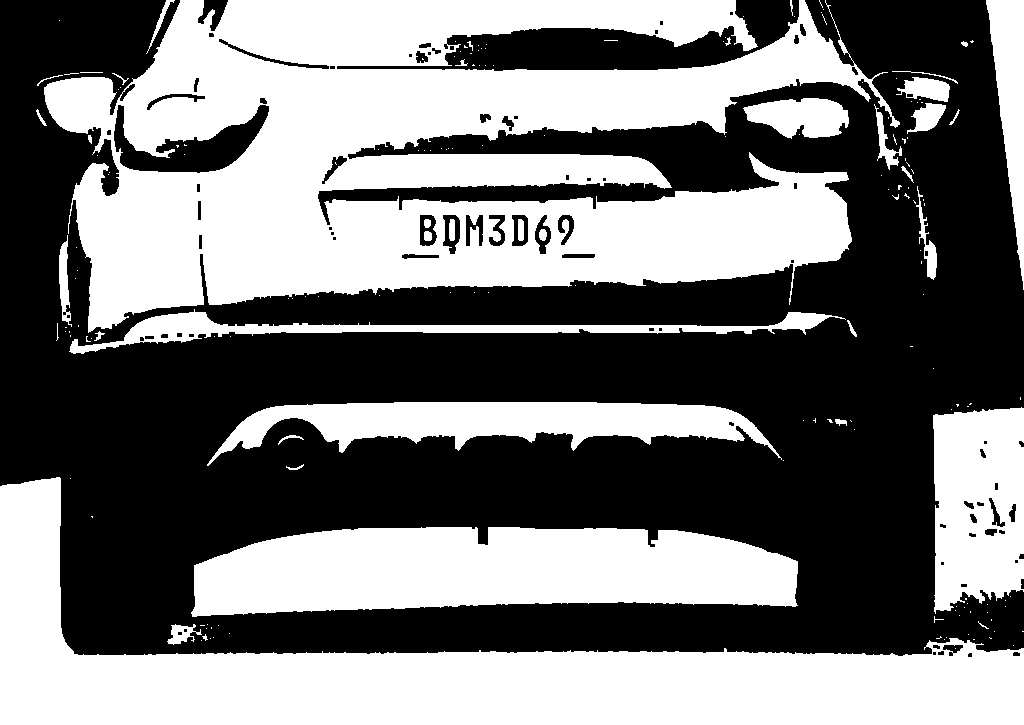

In [ ]:
fechamento = cv2.morphologyEx(carro, cv2.MORPH_CLOSE, kernel_quadrado)
valor, mascara = cv2.threshold(fechamento, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(mascara)

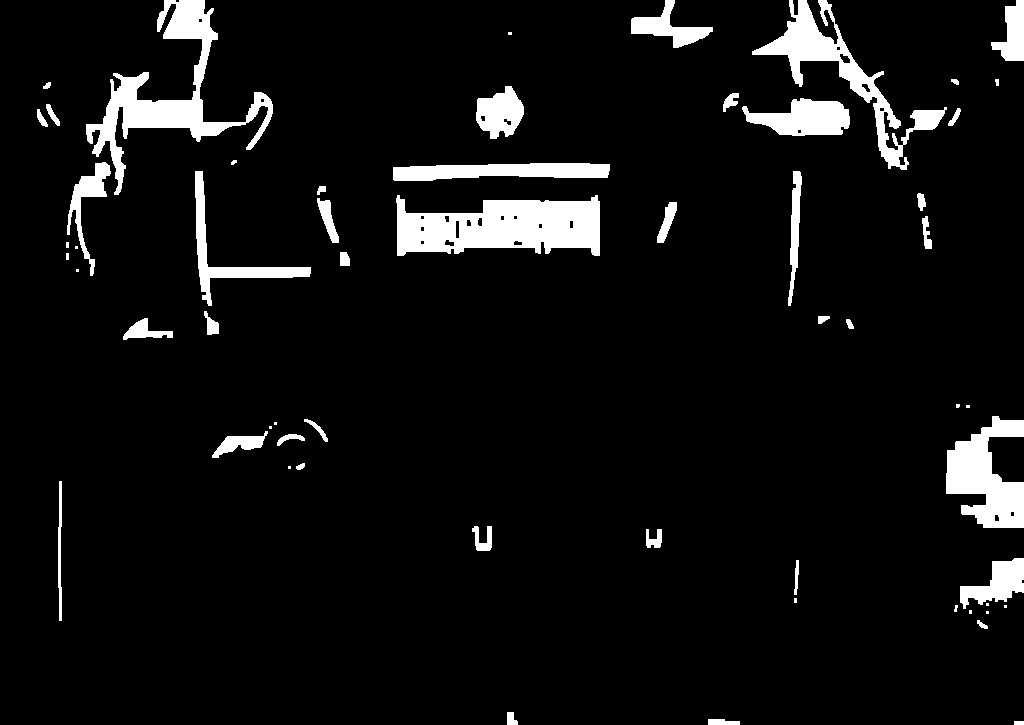

In [ ]:
limiarizacao = cv2.bitwise_and(limiarizacao, limiarizacao, mask = mascara)
limiarizacao = cv2.dilate(limiarizacao, kernel_quadrado, iterations = 2)
limiarizacao = cv2.erode(limiarizacao, kernel_quadrado)
cv2_imshow(limiarizacao)

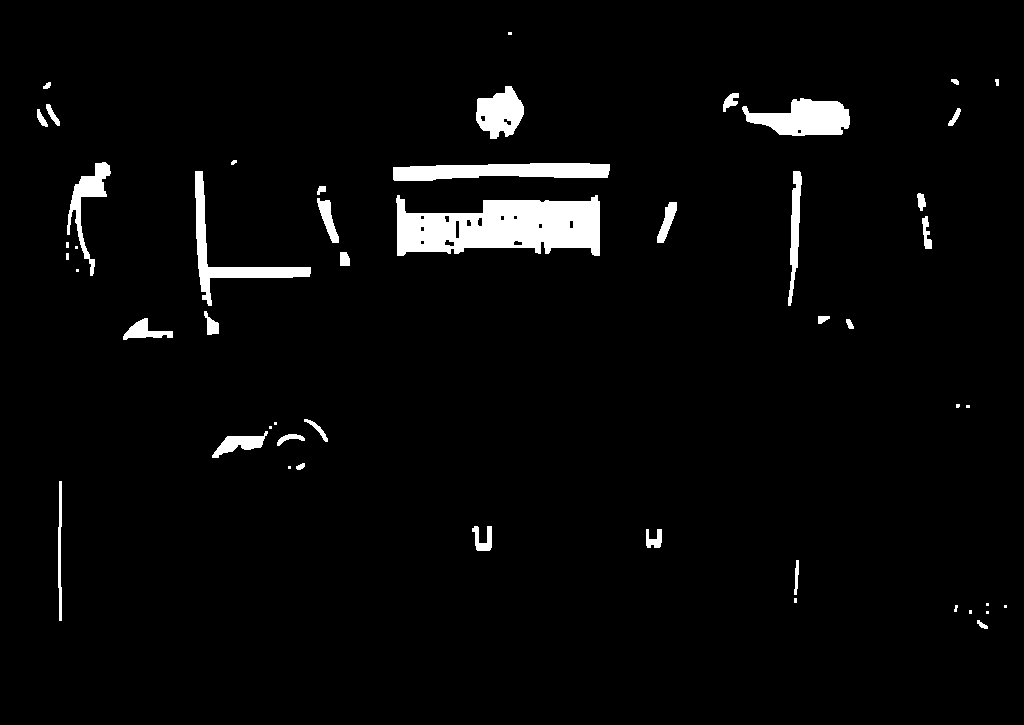

In [ ]:
from skimage.segmentation import clear_border
limiarizacao = clear_border(limiarizacao)
cv2_imshow(limiarizacao)

In [ ]:
contornos, hierarquia = cv2.findContours(limiarizacao, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contornos = sorted(contornos, key = cv2.contourArea, reverse = True)[:10]
contornos

[array([[[397, 195]],
 
        [[397, 197]],
 
        [[396, 198]],
 
        [[396, 202]],
 
        [[397, 203]],
 
        [[397, 255]],
 
        [[403, 255]],
 
        [[405, 253]],
 
        [[405, 252]],
 
        [[406, 251]],
 
        [[446, 251]],
 
        [[448, 253]],
 
        [[450, 253]],
 
        [[450, 249]],
 
        [[451, 248]],
 
        [[453, 248]],
 
        [[454, 249]],
 
        [[454, 253]],
 
        [[458, 253]],
 
        [[460, 251]],
 
        [[463, 251]],
 
        [[463, 248]],
 
        [[464, 247]],
 
        [[534, 247]],
 
        [[535, 248]],
 
        [[535, 252]],
 
        [[537, 252]],
 
        [[538, 253]],
 
        [[540, 253]],
 
        [[540, 242]],
 
        [[541, 241]],
 
        [[543, 241]],
 
        [[544, 242]],
 
        [[544, 247]],
 
        [[545, 248]],
 
        [[545, 253]],
 
        [[548, 253]],
 
        [[549, 252]],
 
        [[549, 251]],
 
        [[550, 250]],
 
        [[550, 248]],
 
        [[551, 2

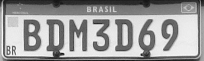

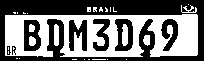

In [ ]:
for contorno in contornos:
    x, y, w, h = cv2.boundingRect(contorno)
    proporcao = float(w)/h
    if proporcao >=3 and proporcao <= 3.5:
        placa = carro[y:y+h, x:x+w]
        valor, regiao_interesse = cv2.threshold(placa, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        regiao_interesse = clear_border(regiao_interesse)
        cv2_imshow(placa)
        cv2_imshow(regiao_interesse)

In [ ]:
texto = image_to_text(regiao_interesse, 'por', '--tessdata-dir tessdata --psm 6')
print(texto)

.BDM3D69



In [ ]:
texto_extraido = re.search('\w{3}\d{1}\w{1}\d{2}', texto)
print(texto_extraido.group(0))

BDM3D69


<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-1682987672.py:1: SyntaxWarning: invalid escape sequence '\w'
  texto_extraido = re.search('\w{3}\d{1}\w{1}\d{2}', texto)
